In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Investigating Fake News Detection with Scikit-Learn

Detecting so-called fake news is no easy task. First, there is defining what is fake news -- given it has now become a political statement. If we can find or agree upon a definition, then we must collect and properly label real and fake news (hopefully on similar topics to best show clear distinctions). Once collected, we must then find useful features to determine fake from real news. For a more in-depth look at this problem space, I recommend taking a look at Miguel Martinez-Alvarez's post ["How can Machine Learning and AI Help Solve the Fake News Problem"](https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/).

Around the same time I read Miguel's insightful post, I came across an open data science post about [building a successful fake news detector with Bayesian models](https://opendatascience.com/blog/how-to-build-a-fake-news-classification-model/). The author even created a [repository with the dataset of tagged fake and real news examples](https://github.com/GeorgeMcIntire/fake_real_news_dataset). I was curious if I could easily reproduce the results, and if I could then determine what the model had learned. 

### Data Exploration

To begin, I wanted to take a quick look at the data and get a feel for its contents. To do so, I used a Pandas dataframe and checked the shape, head and applied some necessary transformations.

In [3]:
df = pd.read_csv('fake_or_real_news.csv')

In [4]:
df.shape

(6335, 4)

In [5]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
df = df.set_index('Unnamed: 0')

In [7]:
df.head()

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Extracting the training data

Now that my dataframe looked closer to what I needed, I wanted to separate my labels and set up training and test datasets. I decided to focus on using the longer article text. I knew I would be using bag-of-words and tf-idf to extract features, so this seemed like a good choice (having longer text and possibly less overlap of word choice).

In [8]:
y = df.label

In [9]:
df = df.drop('label', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

### Building Vectorizer Classifiers

Now that I had my training and testing data, I wanted to build my classifiers. I thought I would begin by using CountVectorizer and TfidfVectorizer. This would give me a good idea if the words and tokens in the articles had a significant impact on whether it was fake or real news. 

I decided to set a max threshhold of `.7` for my tf-idf vectorizer (removing words that appear in more than 70% of the articles) and I used the built in `stop_words` to remove English stop words from the two. There are many more settings, which you can read about in the scikit-learn documentation for [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

I then took a look at my vector features, and noticed I might have some issues immediately. There were clearly comments, measurements or other nonsensical words as well as multilingual articles in my dataset. Normally, I would want to spend more time preprocessing this and removing noise, but as a small proof of concept -- I would see if the model could overcome the noise and properly classify despite these issues.

In [13]:
tfidf_vectorizer.get_feature_names()[-10:]

['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']

In [14]:
count_vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '00000031',
 '000035',
 '00006',
 '0001',
 '0001pt',
 '000ft',
 '000km']

### Comparing Models

Now it was time to train and test my models. I would begin with an NLP favorite, MultinomialNB. I wanted to compare tf-idf versus bag-of-words with this and my intuition was that bag of words (aka CountVectorizer) would perform better. (For more reading on multinomial distribution, check out this [fairly succinct explanation from a UPenn statistics course](https://onlinecourses.science.psu.edu/stat504/node/40)).

I personally find Confusion Matrices easier to compare and read, so I used the scikit-learn documentation to build some easily-readible confusion matrices (thanks open source!).

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [16]:
clf = MultinomialNB() 

accuracy:   0.857
Confusion matrix, without normalization


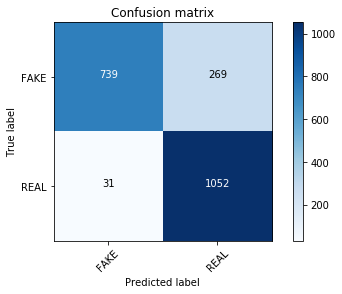

In [17]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [18]:
clf = MultinomialNB() 

accuracy:   0.893
Confusion matrix, without normalization


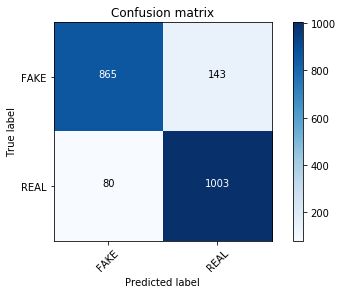

In [19]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

And indeed, with absolutely no parameter tuning, my count vectorized training set was visibly outperforming my tf-idf vectors!

### Testing Linear Models

There are a lot of great writeups about how linear models work well with tf-idf vectorizers (see: [word2vec for classification](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [SVM reference in scikit-learn text analysis](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set), and many more). 

So I used a SVM, right? Well, I recently watched [Victor Lavrenko's lecture on text classification]( https://www.youtube.com/watch?v=4LINLfsq1yE&list=PLBv09BD7ez_4XyTO5MnDLV9N-s6kgXQy7) and I had not used a Passive Aggressive classifier previously. I decided to test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news dataset. 

In [44]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

accuracy:   0.934
Confusion matrix, without normalization


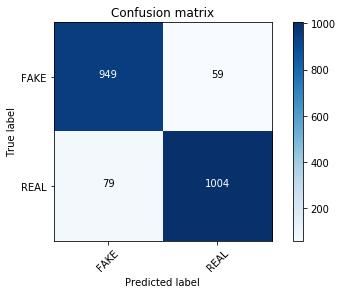

In [45]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Wow! I was impressed. My confusion matrix looks much different. I was curious if tuning my `alpha` value for a MultinomialNB could allow for comprable results. I could have also used [parameter tuning with grid search](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#parameter-tuning-using-grid-search) for a more exhaustive search.

In [22]:
clf = MultinomialNB(alpha=0.1)

In [23]:
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.61502
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


/home/katharine/.virtualenv/py3data/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


Not quite... It might be interesting to perform parameter tuning across all of the classifiers, or take a look at some other [scikit-learn Bayesian classifiers](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) and compare results. I could also test with a SVM to see if that outperforms the Passive Aggressive classifier.

But at this point I was a bit more curious about what the Passive Aggressive model actually *had* learned. So I decided to move onto introspection.

### Introspecting models

So fake news is solved, right? I achieved 93% accuracy on my dataset so let's all close up shop and go home. 😂

Not quite, of course. I was wary at best of these results given how much noise I had seen in my initial features. There is a great writeup [on StackOverflow](https://stackoverflow.com/a/26980472) with this incredibly useful function for finding vectors that most affect labels. It only works for classifiers with 2 classes, but that's good news for us, since we only have FAKE or REAL labels. 

Using my best performing classifier with my tf-idf vector dataset and Passive Aggressive classifier, I decided to inspect the top vectors for fake and real news.

In [46]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf)

FAKE -5.09559192291 2016
FAKE -4.24140290493 october
FAKE -4.05900747213 hillary
FAKE -3.22885562621 share
FAKE -3.00853078415 article
FAKE -3.00147656502 november
FAKE -2.50051210071 print
FAKE -2.35858028602 email
FAKE -2.31740593968 oct
FAKE -2.2966478703 mosul
FAKE -2.25499032576 source
FAKE -2.21682874719 war
FAKE -2.14868090283 advertisement
FAKE -2.05624340536 pipeline
FAKE -2.04395901428 establishment
FAKE -1.99828979782 election
FAKE -1.98608613102 nov
FAKE -1.94016370587 podesta
FAKE -1.91745281166 brexit
FAKE -1.85688711835 snip
FAKE -1.83654742194 corporate
FAKE -1.80282076289 wikileaks
FAKE -1.79188268967 jewish
FAKE -1.79099095412 26
FAKE -1.79036904095 daesh
FAKE -1.72875667221 youtube
FAKE -1.68001278018 ayotte
FAKE -1.66119086372 photo
FAKE -1.63706393926 reuters
FAKE -1.62294604177 com
FAKE -1.59400111813 donald
FAKE -1.58765222145 entire
FAKE -1.55230297966 dakota
FAKE -1.55008093683 uk
FAKE -1.54682488752 reno
FAKE -1.53626451329 watch
FAKE -1.53166319901 dr
FAKE -1

You can also do this in a pretty obvious way with only a few lines of Python, by zipping your coefficients to your features and taking a look at the top and bottom of your list.

In [47]:
feature_names = tfidf_vectorizer.get_feature_names()

In [52]:
### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(4.5904876453855605, 'said'),
 (2.7094447399526369, 'tuesday'),
 (2.473679318978534, 'gop'),
 (2.4735534206294103, 'says'),
 (2.3766859161625407, 'monday'),
 (2.3370552296759741, 'islamic'),
 (2.3259049587243985, 'marriage'),
 (2.2749688039790148, 'cruz'),
 (2.2400757194292473, 'conservative'),
 (2.2372983539156635, 'candidates'),
 (2.220871773078025, 'sunday'),
 (2.2047045442856872, 'rush'),
 (2.1574293152671795, 'debate'),
 (2.1552094691886605, 'friday'),
 (2.0240124334601193, 'sen'),
 (1.9689921054091095, 'continue'),
 (1.9035271782086991, 'attacks'),
 (1.8986131092562575, 'presumptive'),
 (1.8945708461335182, 'march'),
 (1.8797572529344653, 'jobs')]

In [49]:
### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-5.0112442093940883, '2016'),
 (-4.2395359353595419, 'hillary'),
 (-4.2023994623267278, 'october'),
 (-3.4525728208012016, 'share'),
 (-3.0468560092652468, 'november'),
 (-2.9958766237727761, 'article'),
 (-2.5472048199853643, 'print'),
 (-2.4464254387005591, 'email'),
 (-2.378341779297656, 'oct'),
 (-2.3162430824205007, 'mosul'),
 (-2.303418293975918, 'war'),
 (-2.1937109307983995, 'advertisement'),
 (-2.1650049196671231, 'election'),
 (-2.1265430550260618, 'establishment'),
 (-2.1037797695404894, 'nov'),
 (-1.9787422103597994, 'source'),
 (-1.8964637974836234, 'corporate'),
 (-1.7946268223530104, 'brexit'),
 (-1.78324675380371, 'podesta'),
 (-1.7554268374700908, 'jewish')]

So, clearly there are certain words that we can recognize in these sets that might show political intent and source (such as corporate and establishment in the fake dataset). I was curious to see that the real news uses forms of the verb "to say" more often, likely because in newspapers and most journalistic publications sources are quoted directly (German Chancellor Angela Merkel says...). 

To extract the full list from my current classifier and take a look at each token (or easily compare tokens from classifier to classifier), I can easily export it like so.

In [28]:
tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))

### Conclusion

So was my fake news classifier experiment a success? Definitely not. But did I get to play around with a new dataset and test out some NLP classification models and introspect how successful they were? Yes. 

As expected from the outset, defining fake news with simple bag-of-words or tf-idf vectors is not the best approach. Especially with a multilingual dataset full of noisy tokens. If we hadn't taken a look at what our model had actually learned, we might have thought we learned something meaningful. So, remember, always introspect your models (as best you can!).

I also experimented a bit with looking at the other classifiers and what they had learned, but this was only a few hours to test proof of concept. I would be curious if you find other trends in the data I might have missed. I hope to follow up with a post on how the classifiers compare in terms of important features [on my blog](https://blog.kjamistan.com). If you spend some time researching and find anything interesting, feel free to share your findings and notes in the comments or you can always reach out on Twitter (I'm [@kjam](https://twitter.com/kjam)).

I hope you had some fun exploring a new NLP dataset with me!

### Appendix A: Count vs Tfidf Features

I was also curious if my count and TF-IDF vectorizers had extracted different tokens. To take a look, I extracted the vector information back into a dataframe to take a look at the features and vectors. I found they extracted the same tokens, but obviously had different weights. Likely, changing the max_df and min_df of the TF-IDF vectorizer might change this result and lead to different features in each.

In [29]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [30]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [31]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

In [32]:
print(count_df.equals(tfidf_df))

False


In [33]:
count_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
tfidf_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Appendix B: HashingVectorizer

I was also curious about whether a HashingVectorizer would work well. HashingVectorizer's require less memory and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. You can read a bit more about the pros and cons of using [`HashingVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) in the scikit-learn documentation if you are interested.

I decided to give it a try and compare its results versus the other vectorizers. It performed fairly well, with better results than the tf-idf vectorizer using MultinomialNB (this is somewhat expected due to the same reasons CountVectorizers perform better). 

In [35]:
hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)

In [36]:
clf = MultinomialNB(alpha=.01)

accuracy:   0.902
Confusion matrix, without normalization


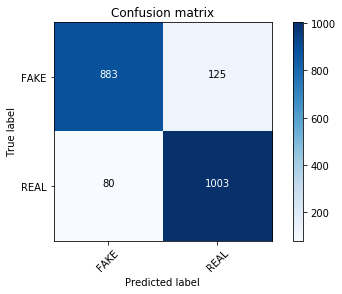

In [37]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [38]:
clf = PassiveAggressiveClassifier(n_iter=50)

accuracy:   0.921
Confusion matrix, without normalization


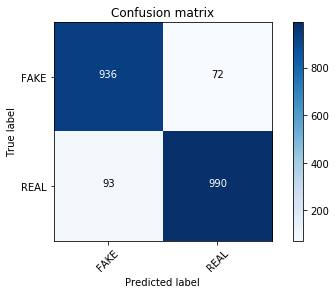

In [39]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])